<a href="https://colab.research.google.com/github/kartikgill/The-GAN-Book/blob/main/Skill-09/SR-GAN/super-resolution-SRGAN/Super-Resolution-GAN-Human_Faces.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Useful Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline

In [ ]:
import tensorflow
print (tensorflow.__version__)

2.4.0


# Load and Unzip Data

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip /content/gdrive/MyDrive/GAN_datasets/face_scrub.zip -d /

In [ ]:
import glob
train = glob.glob('/*_faces/*/*.jpeg')[:35000]
test = glob.glob('/*_faces/*/*.jpeg')[35000:]
len(train), len(test)

(35000, 7196)

In [ ]:
import cv2
for file in train[:10]:
    img = cv2.imread(file)
    print (img.shape)

(176, 176, 3)
(357, 357, 3)
(120, 120, 3)
(141, 141, 3)
(105, 105, 3)
(119, 119, 3)
(167, 167, 3)
(103, 103, 3)
(107, 107, 3)
(120, 120, 3)


# Display Data Samples (64x64 --> 256x256)

Low quality Samples


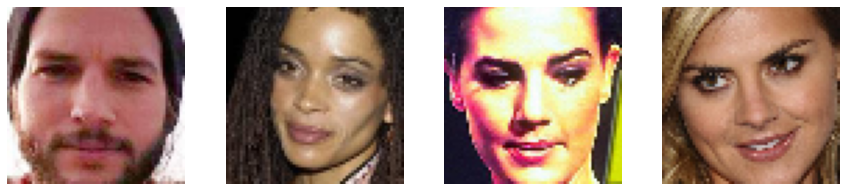

----------------------------------------------------------------------------------------------------
Real High quality version


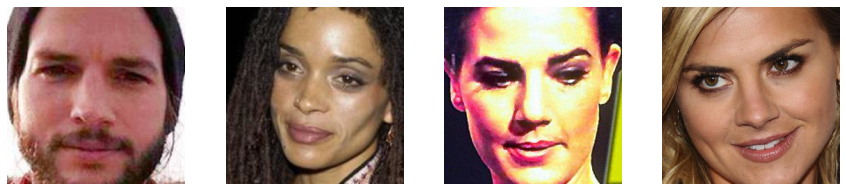

In [ ]:
import cv2

files = np.random.choice(train, size=4)

print ("Low quality Samples")
for k in range(1):
    plt.figure(figsize=(15, 15))
    for j, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (64, 64))
        plt.subplot(440 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

print ("-"*100)
print ("Real High quality version")
for k in range(1):
    plt.figure(figsize=(15, 15))
    for j, file in enumerate(files):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))
        plt.subplot(440 + 1 + j)
        plt.imshow(img)
        plt.axis('off')
        #plt.title(trainY[i])
    plt.show()

# Define Generator Model (Resnet Like)

In [ ]:
import tensorflow_addons as tfa

In [ ]:
def custom_resnet_block(input_layer, filters, upsample=False, resnet=True):
    x = input_layer
    if resnet==True:
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
        x = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(x)

        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tfa.layers.InstanceNormalization()(x)

        # Skip Connection
        x = tensorflow.keras.layers.Add()([x, input_layer])
    
    if upsample==True:
        x = tensorflow.keras.layers.UpSampling2D(size=2)(x)
        x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        x = tensorflow.keras.layers.Activation('relu')(x)
    return x

In [ ]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))

first = tensorflow.keras.layers.Conv2D(64, kernel_size=9, strides=1, padding='same')(low_quality_image)
first = tensorflow.keras.layers.Activation('relu')(first)

x = custom_resnet_block(first, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)
x = custom_resnet_block(x, 64, False)

y = tensorflow.keras.layers.Conv2D(64, kernel_size=3, strides=1, padding='same')(x)
y = tensorflow.keras.layers.BatchNormalization(momentum=0.8)(y)
y = tensorflow.keras.layers.Add()([y, first])

z = custom_resnet_block(y, 256, True, False)
z = custom_resnet_block(z, 256, True, False)

z = tensorflow.keras.layers.Conv2D(3, kernel_size=9, strides=1, padding='same')(z)
high_quality_image = tensorflow.keras.layers.Activation('tanh')(z)

In [ ]:
generator_network = tensorflow.keras.models.Model(inputs=low_quality_image, outputs=high_quality_image)
print (generator_network.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 64)   15616       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 64, 64, 64)   36928       activation[0][0]                 
______________________________________________________________________________________________

# Define Discriminator Network

In [ ]:
def custom_d_block(input_layer, filters, strides, bn=True):
    x = tensorflow.keras.layers.Conv2D(filters, kernel_size=3, strides=strides, padding='same')(input_layer)
    x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)
    if bn==True:
        x = tfa.layers.InstanceNormalization()(x)
    return x

In [ ]:
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

x = custom_d_block(high_quality_input, 64, 1, False)
x = custom_d_block(x, 64, 2, True)
x = custom_d_block(x, 128, 1, True)
x = custom_d_block(x, 128, 2, True)
x = custom_d_block(x, 256, 1, True)
x = custom_d_block(x, 256, 2, True)
x = custom_d_block(x, 512, 1, True)
x = custom_d_block(x, 512, 2, True)

x = tensorflow.keras.layers.Dense(1024)(x)
x = tensorflow.keras.layers.LeakyReLU(alpha=0.2)(x)

real_vs_fake_patch = tensorflow.keras.layers.Dense(1, activation='sigmoid')(x)

In [ ]:
discriminator_network = tensorflow.keras.models.Model(inputs=high_quality_input, outputs=real_vs_fake_patch)
print (discriminator_network.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128, 128, 64)      0         
_________________________________________________________________
instance_normalization_16 (I (None, 128, 128, 64)      128       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 128, 128, 128)     7385

In [ ]:
adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

discriminator_network.compile(loss='mse', optimizer=adam_optimizer, metrics=['accuracy'])

# Loading Pre Trained VGG feaures

In [ ]:
image_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

pre_trained_vgg = tensorflow.keras.applications.vgg19.VGG19(weights='imagenet', input_shape=(256, 256, 3), include_top=False)
pre_trained_vgg_model = tensorflow.keras.models.Model(inputs=pre_trained_vgg.input, outputs=pre_trained_vgg.get_layer('block3_conv4').output)

pre_trained_image_feautures = pre_trained_vgg_model(image_input)

custom_vgg = tensorflow.keras.models.Model(inputs=image_input, outputs=pre_trained_image_feautures)
print (custom_vgg.summary())

80142336/80134624 [==============================] - 1s 0us/step
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 64, 64, 256)       2325568   
Total params: 2,325,568
Trainable params: 2,325,568
Non-trainable params: 0
_________________________________________________________________
None


# Define Super Resolution GAN or SR-GAN

In [ ]:
low_quality_image = tensorflow.keras.layers.Input(shape=(64, 64, 3))
high_quality_input = tensorflow.keras.layers.Input(shape=(256, 256, 3))

fake_high_quality_image = generator_network(low_quality_image)

discriminator_network.trainable=False
custom_vgg.trainable=False

d_output = discriminator_network(fake_high_quality_image)
fake_high_quality_features = custom_vgg(fake_high_quality_image)

sr_gan = tensorflow.keras.models.Model(inputs=[low_quality_image, high_quality_input],\
                                                   outputs=[d_output, fake_high_quality_features])

print (sr_gan.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
model (Functional)              (None, 256, 256, 3)  2040643     input_5[0][0]                    
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Functional)            (None, 16, 16, 1)    5215425     model[0][0]                      
____________________________________________________________________________________________

# Compiling Models

In [ ]:
sr_gan.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[0.001, 1], optimizer=adam_optimizer)

# Define Data Generators

In [ ]:
from tqdm import tqdm_notebook
new_train = []
for file in tqdm_notebook(train):
    img = cv2.imread(file)
    if (img.shape[0] >= 256):
        new_train.append(file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
len(new_train)

10330

In [ ]:
def get_training_samples(batch_size):
    files = np.random.choice(new_train, size=batch_size)
    low_quality_images = []
    high_quality_images = []
    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img, (256, 256))
        img3 = cv2.resize(img, (64, 64))
        low_quality_images.append((img3-127.5)/127.5)
        high_quality_images.append((img2-127.5)/127.5)
    low_quality_images = np.array(low_quality_images)
    high_quality_images = np.array(high_quality_images)
    return low_quality_images, high_quality_images

def show_generator_results(generator_network):
    low_quality_images, high_quality_images = get_training_samples(3)
    fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

    print ("Low quality input images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((low_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Generated high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((fake_high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Real high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

# Training SR-GAN

In [ ]:
len(new_train)

10330

Low quality input images


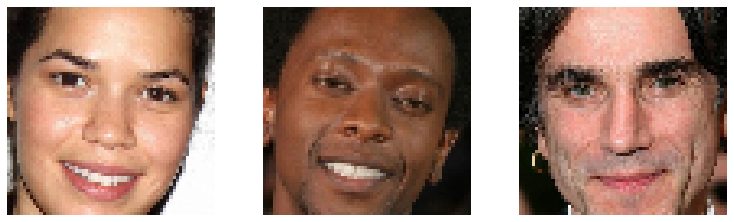

Generated high quality images


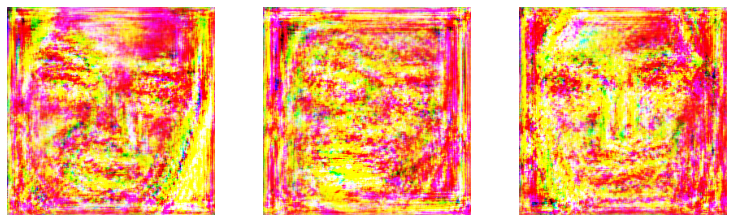

Real high quality images


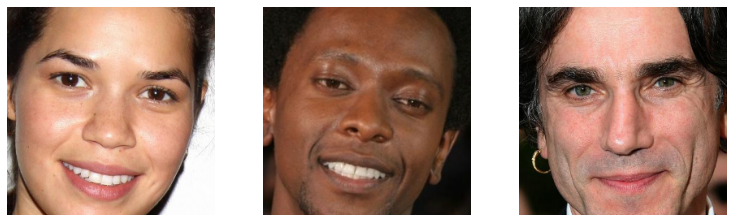

Epoch:0, Step:0, D-Loss:0.303, D-Acc:48.047, G-Loss:336.211
Epoch:0, Step:200, D-Loss:0.215, D-Acc:78.125, G-Loss:31.675
Epoch:0, Step:400, D-Loss:0.020, D-Acc:99.219, G-Loss:43.861
Epoch:0, Step:600, D-Loss:0.325, D-Acc:53.125, G-Loss:31.401
Epoch:0, Step:800, D-Loss:0.007, D-Acc:99.805, G-Loss:27.879
Epoch:0, Step:1000, D-Loss:0.006, D-Acc:99.609, G-Loss:30.598
Epoch:0, Step:1200, D-Loss:0.003, D-Acc:99.805, G-Loss:34.514
Epoch:0, Step:1400, D-Loss:0.058, D-Acc:94.531, G-Loss:47.920
Epoch:0, Step:1600, D-Loss:0.000, D-Acc:100.000, G-Loss:47.942
Epoch:0, Step:1800, D-Loss:0.000, D-Acc:100.000, G-Loss:20.406
Low quality input images


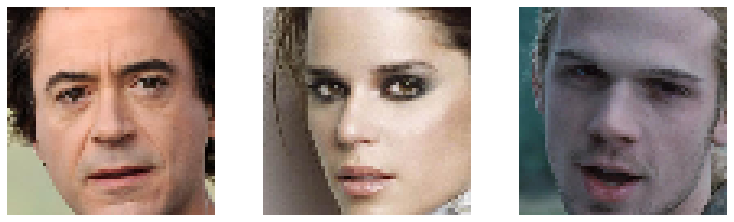

Generated high quality images


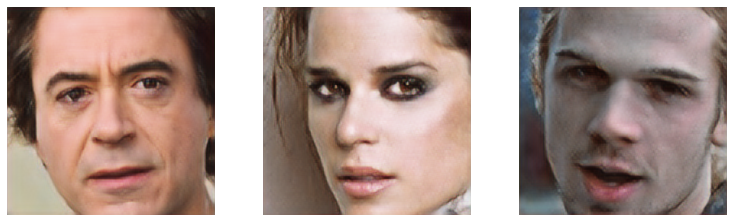

Real high quality images


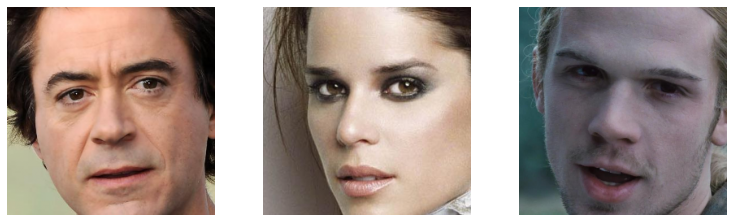

Epoch:1, Step:0, D-Loss:0.001, D-Acc:100.000, G-Loss:40.556
Epoch:1, Step:200, D-Loss:0.000, D-Acc:100.000, G-Loss:18.526
Epoch:1, Step:400, D-Loss:0.000, D-Acc:100.000, G-Loss:37.757
Epoch:1, Step:600, D-Loss:0.000, D-Acc:100.000, G-Loss:20.622
Epoch:1, Step:800, D-Loss:0.000, D-Acc:100.000, G-Loss:40.916
Epoch:1, Step:1000, D-Loss:0.000, D-Acc:100.000, G-Loss:34.402
Epoch:1, Step:1200, D-Loss:0.000, D-Acc:100.000, G-Loss:28.105
Epoch:1, Step:1400, D-Loss:0.001, D-Acc:100.000, G-Loss:63.562
Epoch:1, Step:1600, D-Loss:0.003, D-Acc:100.000, G-Loss:15.544
Epoch:1, Step:1800, D-Loss:0.000, D-Acc:100.000, G-Loss:36.851
Low quality input images


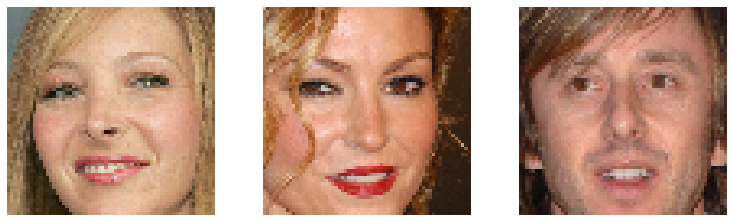

Generated high quality images


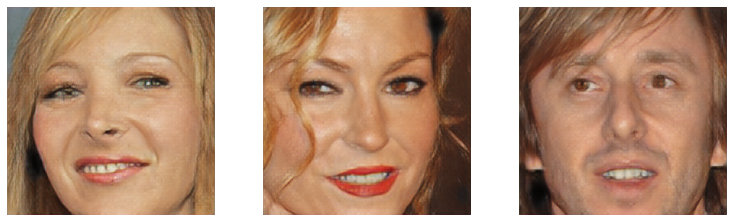

Real high quality images


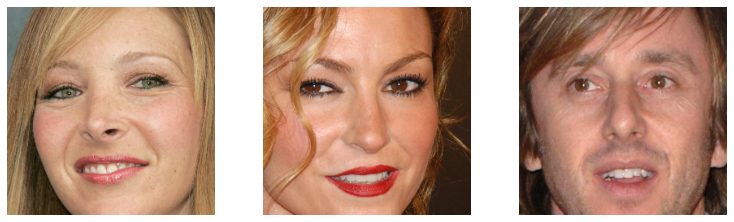

Epoch:2, Step:0, D-Loss:0.000, D-Acc:100.000, G-Loss:19.534


KeyboardInterrupt: ignored

In [ ]:
epochs = 500
batch_size = 1
steps = 2000

for i in range(0, epochs):
    if (i%1 == 0):
        show_generator_results(generator_network)
    for j in range(steps):
        low_quality_images, high_quality_images = get_training_samples(batch_size)

        fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

        fake_patch = np.zeros((batch_size, 16, 16, 1))
        real_patch = np.ones((batch_size, 16, 16, 1))
        
        # Updating Discriminator weights
        discriminator_network.trainable=True
        loss_d_real = discriminator_network.train_on_batch(high_quality_images, real_patch)
        loss_d_fake = discriminator_network.train_on_batch(fake_high_quality_images, fake_patch)
        loss_d = np.add(loss_d_real, loss_d_fake)/2.0
        
        # Make the Discriminator belive that these are real samples and calculate loss to train the generator
        low_quality_images, high_quality_images = get_training_samples(batch_size)
        discriminator_network.trainable=False

        real_vgg_features = custom_vgg.predict_on_batch(high_quality_images)

        # Updating Generator weights
        loss_g = sr_gan.train_on_batch([low_quality_images, high_quality_images], [real_patch, real_vgg_features])
        
        if j%200 == 0:
            print ("Epoch:%.0f, Step:%.0f, D-Loss:%.3f, D-Acc:%.3f, G-Loss:%.3f"%(i,j,loss_d[0],loss_d[1]*100,loss_g[0]))

# Check Results

In [ ]:
from tqdm import tqdm_notebook
new_test = []
for file in tqdm_notebook(test):
    img = cv2.imread(file)
    if (img.shape[0] >= 256):
        new_test.append(file)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
len(new_test)

2429

In [ ]:
def show_test_results(generator_network):
    files = np.random.choice(new_test, size=3)
    low_quality_images = []
    high_quality_images = []
    for file in files:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img2 = cv2.resize(img, (256, 256))
        img3 = cv2.resize(img, (64, 64))
        low_quality_images.append((img3-127.5)/127.5)
        high_quality_images.append((img2-127.5)/127.5)

    low_quality_images = np.array(low_quality_images)
    high_quality_images = np.array(high_quality_images)

    fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

    print ("Low quality input images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((low_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Generated high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((fake_high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

    print ("Real high quality images")
    plt.figure(figsize=(13, 13))
    for i in range(3):
        plt.subplot(330 + 1 + i)
        plt.imshow((high_quality_images[i]+1.0)/2.0)
        plt.axis('off')
    plt.show()

In [ ]:
for i in range(5):
    show_test_results(generator_network)
    print ("-"*100)
    print ("-"*100)

# Results

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
files = ['/content/gdrive/MyDrive/GAN_datasets/kartik1.jpg', '/content/gdrive/MyDrive/GAN_datasets/brother.jpg']

Low quality input images


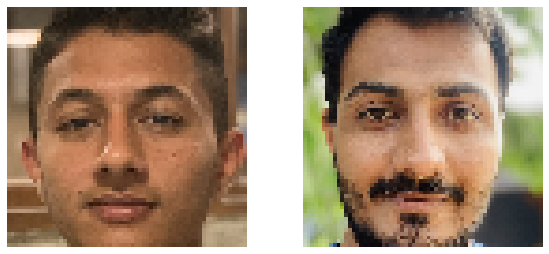

Generated high quality images


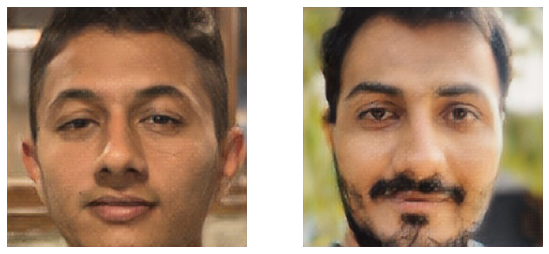

Real high quality images


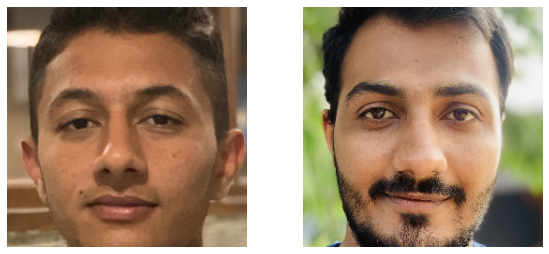

In [ ]:
files = np.random.choice(files, size=2)
low_quality_images = []
high_quality_images = []
for file in files:
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img2 = cv2.resize(img, (256, 256))
    img3 = cv2.resize(img, (64, 64))
    low_quality_images.append((img3-127.5)/127.5)
    high_quality_images.append((img2-127.5)/127.5)

low_quality_images = np.array(low_quality_images)
high_quality_images = np.array(high_quality_images)

fake_high_quality_images = generator_network.predict_on_batch(low_quality_images)

print ("Low quality input images")
plt.figure(figsize=(15, 15))
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow((low_quality_images[i]+1.0)/2.0)
    plt.axis('off')
plt.show()

print ("Generated high quality images")
plt.figure(figsize=(15, 15))
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow((fake_high_quality_images[i]+1.0)/2.0)
    plt.axis('off')
plt.show()

print ("Real high quality images")
plt.figure(figsize=(15, 15))
for i in range(2):
    plt.subplot(330 + 1 + i)
    plt.imshow((high_quality_images[i]+1.0)/2.0)
    plt.axis('off')
plt.show()